# Using Haiku as a sub-agent

In this recipe, we'll demonstrate how to analyze Apple's 2023 financial earnings reports using Claude 3 Haiku sub-agent models to extract relevant information from earnings release PDFs. We'll then use Claude 3 Opus to generate a response to our question and create a graph using matplotlib to accompany its response.

## Step 1: Set up the environment
First, let's install the required libraries and set up the Anthropic API client.

In [ ]:
%pip install anthropic IPython PyMuPDF matplotlib

In [89]:
# Import the required libraries
import fitz
import base64
from PIL import Image
import io
from concurrent.futures import ThreadPoolExecutor
from anthropic import Anthropic
import requests
import os

# Set up the Anthropic API client
client = Anthropic()
MODEL_NAME = "claude-3-haiku-20240229"

## Step 2: Gather our documents and ask a question
For this example, we will be using all Apple's financial statements from the 2023 financial year and asking about the net sales over the year.

In [90]:
# List of Apple's earnings release PDF URLs
pdf_urls = [
    "https://www.apple.com/newsroom/pdfs/fy2023-q4/FY23_Q4_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/fy2023-q3/FY23_Q3_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q2_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q1_Consolidated_Financial_Statements.pdf"
]

# User's question
QUESTION = "How did Apple's net sales change quarter to quarter in the 2023 financial year and what were the key contributors to the changes?"

## Step 3: Download and convert PDFs to images
Next, we'll define functions to download the earnings release PDFs and convert them to base64-encoded PNG images. We have to do this because these PDFs are full of tables that are hard to parse with traditional PDF parsers. It's easier if we just convert them to images and pass the images to Haiku.

The ```download_pdf``` function downloads a PDF file from a given URL and saves it to the specified folder. The ```pdf_to_base64_pngs``` function converts a PDF to a list of base64-encoded PNG images.

In [111]:
# Function to download a PDF file from a URL and save it to a specified folder
def download_pdf(url, folder):
    response = requests.get(url)
    if response.status_code == 200:
        file_name = os.path.join(folder, url.split("/")[-1])
        with open(file_name, "wb") as file:
            file.write(response.content)
        return file_name
    else:
        print(f"Failed to download PDF from {url}")
        return None
    
# Define the function to convert a PDF to a list of base64-encoded PNG images
def pdf_to_base64_pngs(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    base64_encoded_pngs = []

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Convert the pixmap to a PIL Image
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)

        # Convert the PIL Image to base64-encoded PNG
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    # Close the PDF document
    doc.close()

    return base64_encoded_pngs

# Folder to save the downloaded PDFs
folder = "../images/using_sub_agents"


# Create the directory if it doesn't exist
os.makedirs(folder)

# Download the PDFs concurrently
with ThreadPoolExecutor() as executor:
    pdf_paths = list(executor.map(download_pdf, pdf_urls, [folder] * len(pdf_urls)))

# Remove any None values (failed downloads) from pdf_paths
pdf_paths = [path for path in pdf_paths if path is not None]

We use ThreadPoolExecutor to download the PDFs concurrently and store the file paths in pdf_paths.

## Step 4: Generate a specific prompt for Haiku using Opus
Let's use Opus as an orchestrator and have it write a specific prompt for each Haiku sub-agent based on the user provided question.

In [102]:
def generate_haiku_prompt(question):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Based on the following question, please generate a specific prompt for an LLM sub-agent to extract relevant information from an earning's report PDF. Each sub-agent only has access to a single quarter's earnings report. Output only the prompt and nothing else.\n\nQuestion: {question}"}
            ]
        }
    ]

    response = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=2048,
        messages=messages
    )

    return response.content[0].text
    
haiku_prompt = generate_haiku_prompt(QUESTION)
print(haiku_prompt)

Extract the following information from the Apple earnings report PDF for the quarter:
1. Apple's net sales for the quarter
2. Quarter-over-quarter change in net sales
3. Key product categories, services, or regions that contributed significantly to the change in net sales
4. Any explanations provided for the changes in net sales

Organize the extracted information in a clear, concise format focusing on the key data points and insights related to the change in net sales for the quarter.


## Step 5: Extract information from PDFs
Now, let's define our question and extract information from the PDFs using sub-agent Haiku models. We format the information from each model into a neatly defined set of XML tags.

In [107]:
def extract_info(pdf_path, haiku_prompt):
    base64_encoded_pngs = pdf_to_base64_pngs(pdf_path)
    
    messages = [
        {
            "role": "user",
            "content": [
                *[{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_encoded_png}} for base64_encoded_png in base64_encoded_pngs],
                {"type": "text", "text": haiku_prompt}
            ]
        }
    ]
    
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2048,
        messages=messages
    )
    
    return response.content[0].text, pdf_path

def process_pdf(pdf_path):
    return extract_info(pdf_path, haiku_prompt)

# Process the PDFs concurrently with Haiku sub-agent models
with ThreadPoolExecutor() as executor:
    extracted_info_list = list(executor.map(process_pdf, pdf_paths))

extracted_info = ""
# Display the extracted information from each model call
for info in extracted_info_list:
    extracted_info += "<info quarter=\"" + info[1].split("/")[-1].split("_")[1] + "\">" + info[0] + "</info>\n"
print(extracted_info)

<info quarter="Q4">According to the condensed consolidated statements of operations, Apple's net sales changed as follows in the 2023 financial year:

Quarter Ended September 30, 2023:
- Total net sales were $89,498 million, up from $90,146 million in the prior year quarter.
- Product sales were $67,184 million and services sales were $22,314 million.

Key contributors to the changes:
- Product sales decreased from $70,958 million in the prior year quarter.
- Services sales increased from $19,188 million in the prior year quarter.

Overall, Apple's total net sales decreased slightly compared to the same quarter in the prior year, driven by a decline in product sales which was partially offset by growth in services sales.</info>
<info quarter="Q3">Based on the financial statements provided, Apple's net sales changed as follows between the quarters in the 2023 financial year:

- Net sales increased from $81,797 million in the three months ended July 1, 2023 to $82,959 million in the thre

We extract information from the PDFs concurrently using sub-agent models and combine the extracted information. We then prepare the messages for the powerful model, including the question and the extracted information, and ask it to generate a response and matplotlib code.

## Step 6: Pass the information to Opus to generate a response
Now that we have fetched the information from each PDF using the sub-agents, let's call Opus to actually answer the question and write code to create a graph to accompany the answer.

In [108]:
# Prepare the messages for the powerful model
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Based on the following extracted information from Apple's earnings releases, please provide a response to the question: {QUESTION}\n\nAlso, please generate Python code using the matplotlib library to accompany your response. Enclose the code within <code> tags.\n\nExtracted Information:\n{extracted_info}"}
        ]
    }
]

# Generate the matplotlib code using the powerful model
response = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=4096,
    messages=messages
)

generated_response = response.content[0].text
print("Generated Response:")
print(generated_response)

Generated Response:
Based on the extracted information from Apple's earnings releases, Apple's net sales changed as follows in the 2023 financial year:

In Q1, net sales increased from $117,154 million in the previous quarter to $123,945 million, driven by increases in both product sales and services revenue.

In Q2, net sales decreased by around $2,442 million compared to the prior six-month period, primarily due to a decrease in product sales, which was partially offset by an increase in services sales.

In Q3, net sales increased by approximately $1,162 million compared to the previous quarter, with growth in both product sales and services sales contributing to the overall increase.

In Q4, total net sales decreased slightly compared to the same quarter in the prior year, driven by a decline in product sales, which was partially offset by growth in services sales.

Here's a Python code snippet using the matplotlib library to visualize the quarterly net sales data:

<code>
import ma

## Step 7: Extract response and execute Matplotlib code
Finally, let's extract the matplotlib code from the generated response and execute it to visualize the revenue growth trend.

We define the ```extract_code_and_response``` function to extract the matplotlib code and non-code response from the generated response. We print the non-code response and execute the matplotlib code if it is found.

Note that it is not good practice to use ```exec``` on model-written code outside of a sandbox but for the purposes of this demo we are doing it :)

Based on the extracted information from Apple's earnings releases, Apple's net sales changed as follows in the 2023 financial year:

In Q1, net sales increased from $117,154 million in the previous quarter to $123,945 million, driven by increases in both product sales and services revenue.

In Q2, net sales decreased by around $2,442 million compared to the prior six-month period, primarily due to a decrease in product sales, which was partially offset by an increase in services sales.

In Q3, net sales increased by approximately $1,162 million compared to the previous quarter, with growth in both product sales and services sales contributing to the overall increase.

In Q4, total net sales decreased slightly compared to the same quarter in the prior year, driven by a decline in product sales, which was partially offset by growth in services sales.

Here's a Python code snippet using the matplotlib library to visualize the quarterly net sales data:


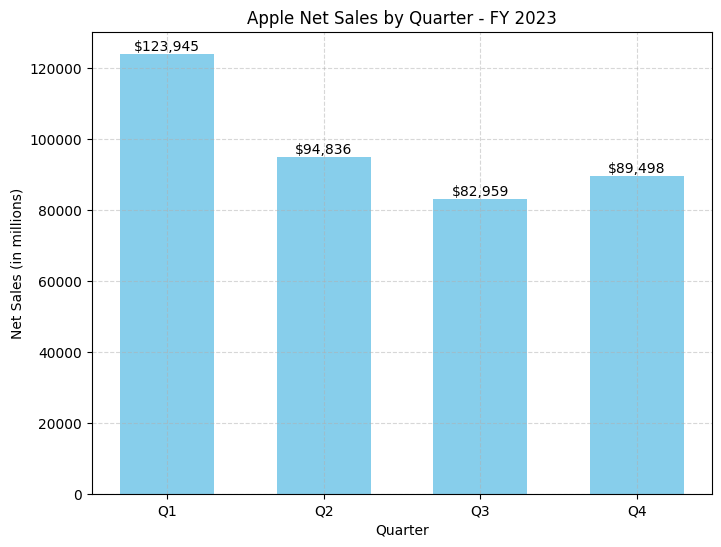

In [112]:
# Extract the matplotlib code from the response
# Function to extract the code and non-code parts from the response
def extract_code_and_response(response):
    start_tag = "<code>"
    end_tag = "</code>"
    start_index = response.find(start_tag)
    end_index = response.find(end_tag)
    if start_index != -1 and end_index != -1:
        code = response[start_index + len(start_tag):end_index].strip()
        non_code_response = response[:start_index].strip()
        return code, non_code_response
    else:
        return None, response.strip()

matplotlib_code, non_code_response = extract_code_and_response(generated_response)

print(non_code_response)
if matplotlib_code:

    # Execute the extracted matplotlib code
    exec(matplotlib_code)
else:
    print("No matplotlib code found in the response.")